# ОБУЧЕНИЕ СЕМАНТИЧЕСКОЙ СЕГМЕНТАЦИИ 

Структура:
- Validation, Validationannot - изображения и маски из валидационного сета в формате Camvid 1.0
- Train, Trainannot - соответственно из трейн сета

Доп файлы:
- label_colors.txt - цвета классов масок сегментаций из трейн и тест сета в формате Camvid 1.0

In [32]:
import numpy as np
import sys
import cv2
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import random 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as albu
%matplotlib inline

In [33]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Параметры

In [34]:
DATSET_NAME = "/Users/anatolii/Desktop/Практика/archive"

X_TRAIN_DIR = f"{DATSET_NAME}/train"
Y_TRAIN_DIR = f"{DATSET_NAME}/trainannot"

X_VALID_DIR = f"{DATSET_NAME}/validation"
Y_VALID_DIR = f"{DATSET_NAME}/validationannot"

X_TEST_DIR = f"{DATSET_NAME}/validation"
Y_TEST_DIR = f"{DATSET_NAME}/validationannot"

LABEL_COLORS_FILE = f"{DATSET_NAME}/label_colors.txt"

Задание констант:

In [35]:
CLASSES = [
    "background",
    "water",  
]
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 70
BATCH_SIZE = 32

INIT_LR = 0.0005
LR_DECREASE_STEP = 15
LR_DECREASE_COEF = 2 # LR будет разделен на этот коэф раз в LR_DECREASE_STEP эпох

INFER_WIDTH = 256
INFER_HEIGHT = 256

loss = utils.losses.DiceLoss()

# Вспомогательные функции

В данном примере в датасете на входе имеется двухканальная (так как 2 класса) фотка где в каждом пикселе стоит во всех каналах 0 кроме одного в котором 1. Тем самым кодируется класс конкретного пикселя в маске

In [36]:
def _convert_multichannel2singlechannel(mc_mask: np.ndarray):
    """ Осуществляет перевод двухканальной маски (число каналов сколько классов) в трехканальное 
    изображение где будет расцветка как зададим в словаре colors_imshow для классов """

    colors_imshow = {
            "background" : np.array([0, 0, 0]),
            "water" : np.array([255, 255, 255])
    }

    sc_mask = np.zeros((mc_mask[0].shape[0], mc_mask[0].shape[1], 3), dtype=np.uint8)
    square_ratios = {}

    for i, singlechannel_mask in enumerate(mc_mask):

        cls = CLASSES[i]
        singlechannel_mask = singlechannel_mask.squeeze()

        # Заодно осуществляет подсчет процента каждого класса (сумма пикселей на общее число)
        square_ratios[cls] = singlechannel_mask.sum() / singlechannel_mask.size
        
        sc_mask += np.multiply.outer(singlechannel_mask > 0, colors_imshow[cls]).astype(np.uint8)
        

    title = "Площади: " + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    return sc_mask, title


def visualize_multichennel_mask(img: np.ndarray, multichennel_mask: np.ndarray):
    """ Реализация демонстрации маски и самого изображения """
    # размер маски: H, W, CHANNEL
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    multichennel_mask = multichennel_mask.transpose(2, 0, 1)
    mask_to_show, title = _convert_multichannel2singlechannel(multichennel_mask)
    axes[1].imshow(mask_to_show)
    axes[1].set_title(title)

    plt.tight_layout()
    plt.show()

# Dataloader

In [37]:
class Dataset(BaseDataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        augmentation=None,
        preprocessing=None
    ):
        self.images_paths = sorted(glob(f"{images_dir}/*"))
        self.masks_paths = sorted(glob(f"{masks_dir}/*"))

        self.cls_colors = self._get_classes_colors(LABEL_COLORS_FILE)

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def _get_classes_colors(self, label_colors_dir):
        cls_colors = {}
        with open(label_colors_dir) as file:
            while line := file.readline():
                R, G, B, label = line.rstrip().split()
                cls_colors[label] = np.array([B, G, R], dtype=np.uint8)

        keyorder = CLASSES
        cls_colors_ordered = {}
        for k in keyorder:
            if k in cls_colors:
                cls_colors_ordered[k] = cls_colors[k]
            elif k=="background":
                cls_colors_ordered[k] = np.array([0, 0, 0], dtype=np.uint8)
            else:
                raise ValueError(f"unexpected label {k}, cls colors: {cls_colors}")

        return cls_colors_ordered

    def __getitem__(self, i):
        image = cv2.imread(self.images_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_paths[i])
        masks = [cv2.inRange(mask, color, color) for color in self.cls_colors.values()]
        masks = [(m > 0).astype("float32") for m in masks]
        mask = np.stack(masks, axis=-1).astype("float")
        
        # sys.stdout.write('\r\n' + str(self.images_paths[i]).split('/')[-1] + 
        #                  '\t' + str(self.masks_paths[i]).split('/')[-1])

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.images_paths)

Демонстрация случайных фотографий тренировочного датасета с их масками:

102


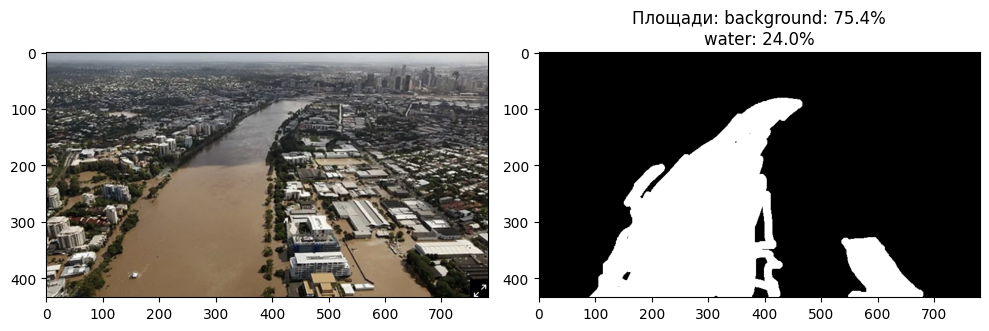

In [38]:
dataset = Dataset(X_TRAIN_DIR, Y_TRAIN_DIR)
k = np.random.randint(len(dataset))
print(k)
image, mask = dataset[k]
visualize_multichennel_mask(image, mask)

# Augmentations

In [39]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
        albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=1, always_apply=True),
        albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True),

        albu.OneOf(
            [
                albu.Sharpen(alpha=(0.1, 0.2), lightness=(0.1, 0.2), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.Blur(blur_limit=[1, 3], p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.GaussNoise(var_limit=(1, 5), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации цвета
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=2, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    # Осуществит стартовую нормализацию данных согласно своим значениям или готовым для imagenet
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Пример аугментаций на train:

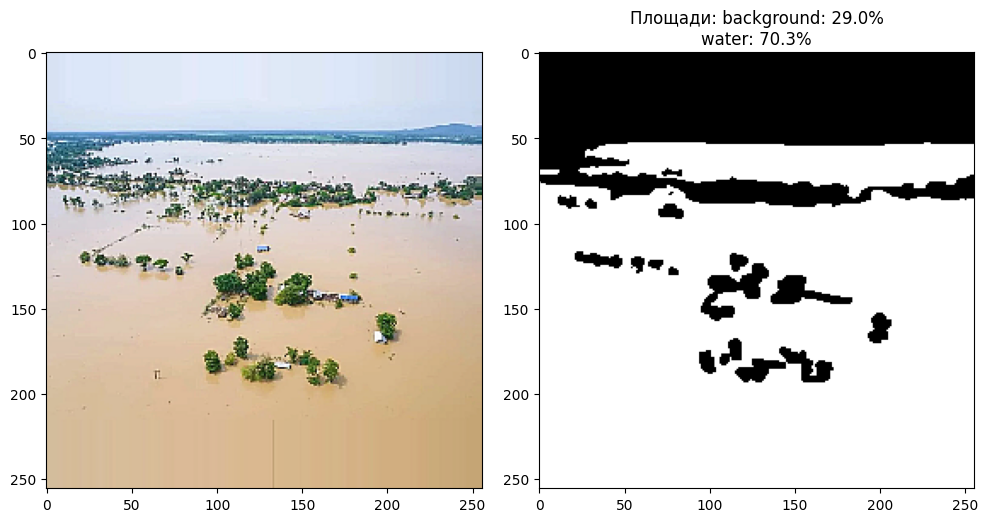

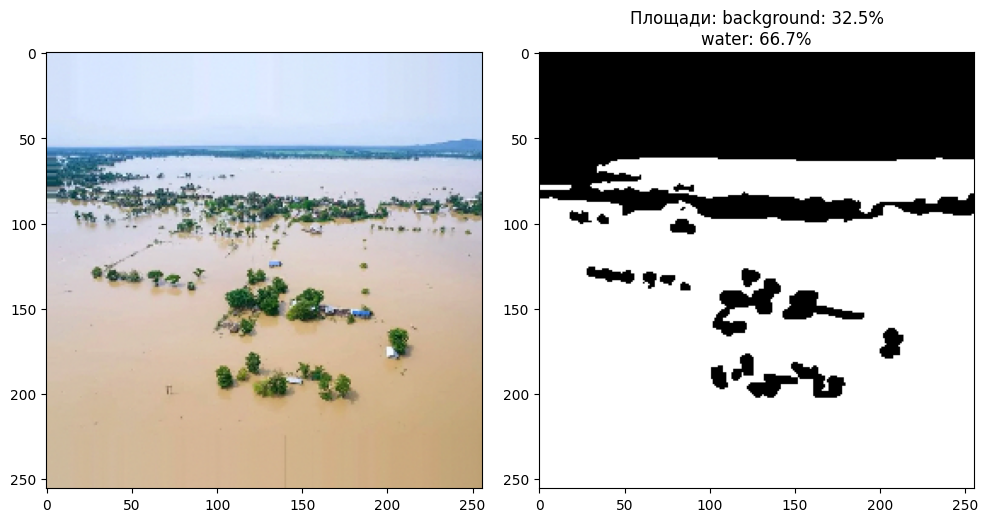

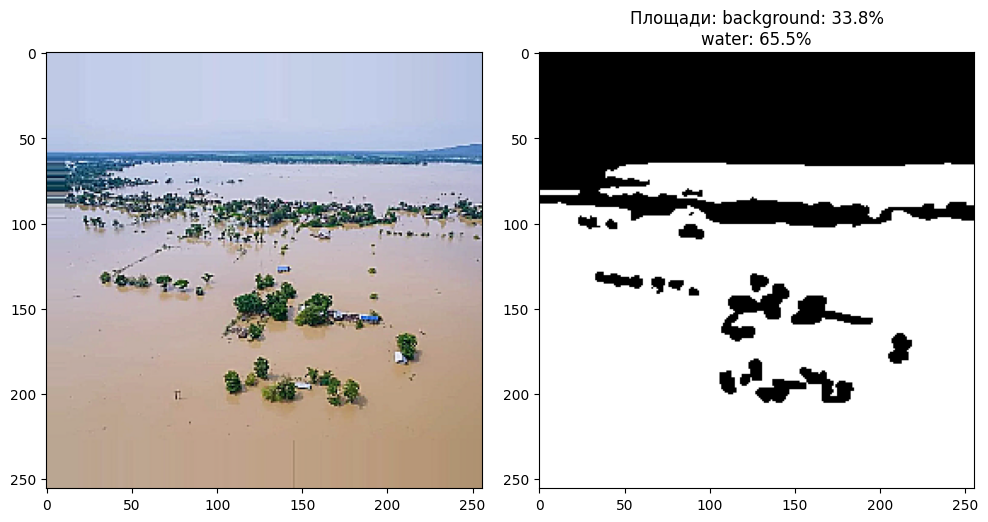

In [40]:
augmented_dataset = Dataset(
    X_TRAIN_DIR, 
    Y_TRAIN_DIR, 
    augmentation=get_training_augmentation()
)

# same image with different random transforms
indx = np.random.randint(len(augmented_dataset))

for i in range(3):
    image, mask = augmented_dataset[indx]
    visualize_multichennel_mask(image, mask)

Пример аугментаций на val:

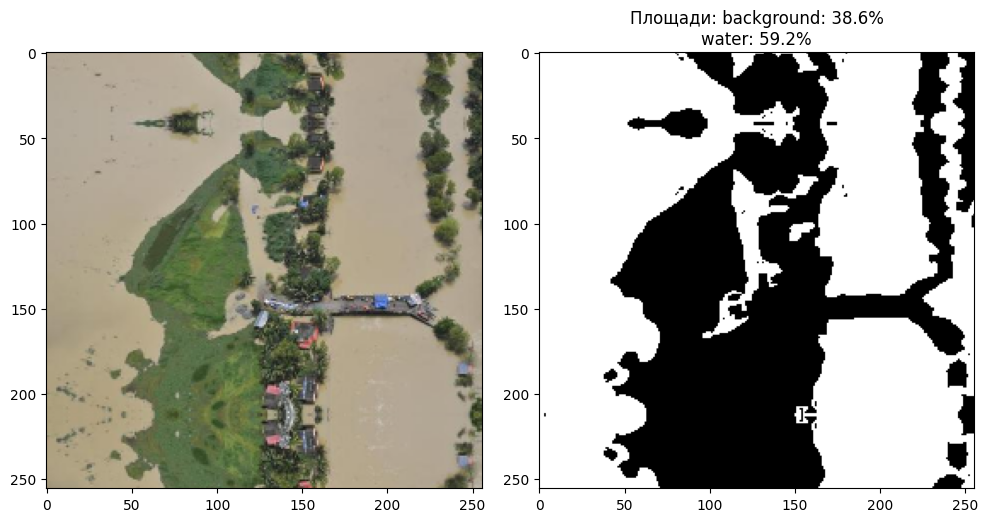

In [41]:
augmented_dataset = Dataset(
    X_VALID_DIR, 
    Y_VALID_DIR, 
    augmentation=get_validation_augmentation()
)

indx = np.random.randint(len(augmented_dataset))

image, mask = augmented_dataset[indx]
visualize_multichennel_mask(image, mask)

# Create model and train

In [11]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [12]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Загрузка нормализации от imagenet

In [13]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
#preprocessing_fn = lambda img, **kwargs: img.astype("float32") / 255    # -- классика деление на 255

In [14]:
preprocessing_fn

functools.partial(<function preprocess_input at 0x3091843a0>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [15]:
train_dataset = Dataset(
    X_TRAIN_DIR, 
    Y_TRAIN_DIR, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    X_VALID_DIR, 
    Y_VALID_DIR, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [16]:
metrics = [
    utils.metrics.Fscore(),
    utils.metrics.IoU()
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=INIT_LR),
])

In [17]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

Обучение:

In [18]:
max_score = 0

loss_logs = {"train": [], "val": []}
metric_logs = {"train": [], "val": []}
for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    train_loss, train_metric, train_metric_IOU = list(train_logs.values())
    loss_logs["train"].append(train_loss)
    metric_logs["train"].append(train_metric_IOU)

    valid_logs = valid_epoch.run(valid_loader)
    val_loss, val_metric, val_metric_IOU = list(valid_logs.values())
    loss_logs["val"].append(val_loss)
    metric_logs["val"].append(val_metric_IOU)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'models/best_model_new.pth')
        # Save the model with JIT
        # Create a tensor with the specified dimensions
        trace_image = torch.randn(BATCH_SIZE, 3, INFER_HEIGHT, INFER_WIDTH)
        # Trace the model using the example input
        traced_model = torch.jit.trace(model, trace_image.to(DEVICE))
        torch.jit.save(traced_model, 'models/best_model_new.pt')
        print('Model saved!')

    print("LR:", optimizer.param_groups[0]['lr'])
    if i > 0 and i % LR_DECREASE_STEP == 0:
        print('Decrease decoder learning rate')
        optimizer.param_groups[0]['lr'] /= LR_DECREASE_COEF


Epoch: 0
valid: 100%|██████████| 47/47 [00:04<00:00, 10.65it/s, dice_loss - 0.1506, fscore - 0.877, iou_score - 0.7853] 


/opt/homebrew/lib/python3.10/site-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


Model saved!
LR: 0.0005

Epoch: 1
valid: 100%|██████████| 47/47 [00:04<00:00, 10.49it/s, dice_loss - 0.128, fscore - 0.8885, iou_score - 0.8046] 
Model saved!
LR: 0.0005

Epoch: 2
valid: 100%|██████████| 47/47 [00:04<00:00, 10.37it/s, dice_loss - 0.1083, fscore - 0.9012, iou_score - 0.8246]
Model saved!
LR: 0.0005

Epoch: 3
valid: 100%|██████████| 47/47 [00:04<00:00, 10.32it/s, dice_loss - 0.1066, fscore - 0.9003, iou_score - 0.823] 
LR: 0.0005

Epoch: 4
valid: 100%|██████████| 47/47 [00:04<00:00, 10.68it/s, dice_loss - 0.09362, fscore - 0.9123, iou_score - 0.8422]
Model saved!
LR: 0.0005

Epoch: 5
valid: 100%|██████████| 47/47 [00:04<00:00, 10.31it/s, dice_loss - 0.1015, fscore - 0.9023, iou_score - 0.8269] 
LR: 0.0005

Epoch: 6
valid: 100%|██████████| 47/47 [00:04<00:00, 10.48it/s, dice_loss - 0.1285, fscore - 0.875, iou_score - 0.7901] 
LR: 0.0005

Epoch: 7
valid: 100%|██████████| 47/47 [00:04<00:00, 10.45it/s, dice_loss - 0.09524, fscore - 0.9079, iou_score - 0.835] 
LR: 0.0005

Ep

KeyboardInterrupt: 

Оценка обучения:

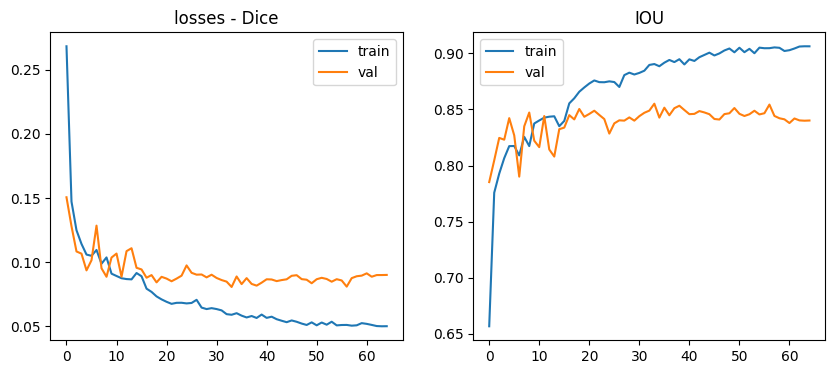

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(loss_logs["train"], label = "train")
axes[0].plot(loss_logs["val"], label = "val")
axes[0].set_title("losses - Dice")

axes[1].plot(metric_logs["train"], label = "train")
axes[1].plot(metric_logs["val"], label = "val")
axes[1].set_title("IOU")

[ax.legend() for ax in axes];

# Test best saved model

In [42]:
# load best saved checkpoint
#best_model = torch.load('models/best_model_new.pth')
best_model = torch.jit.load('models/best_model_new.pt', map_location=DEVICE)

In [43]:
def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=2, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)

In [44]:
# оценка IoU
test_dataset = Dataset(
    X_TEST_DIR, 
    Y_TEST_DIR, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataloader = DataLoader(test_dataset)

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 47/47 [00:04<00:00,  9.46it/s, dice_loss - 0.08069, fscore - 0.9204, iou_score - 0.8551]


# Visualize predictions

In [45]:
colors_imshow = {
        "background" : np.array([0, 0, 0]),
        "water" : np.array([0, 255, 0])
    }


def _colorize_mask(mask: np.ndarray):
    mask = mask.squeeze()
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    square_ratios = {}
    for cls_code, cls in enumerate(CLASSES):
        cls_mask = mask == cls_code
        square_ratios[cls] = cls_mask.sum() / cls_mask.size
        colored_mask += np.multiply.outer(cls_mask, colors_imshow[cls]).astype(np.uint8)

    return colored_mask, square_ratios


def reverse_normalize(img, mean, std):
    # Invert normalization
    img = img * np.array(std) + np.array(mean)
    return img


def visualize_predicts(img: np.ndarray, mask_gt: np.ndarray, mask_pred: np.ndarray, normalized=False):
    # размер img: H, W, CHANNEL
    # размер mask_gt, mask_pred: H, W, значения - range(len(CLASSES)
    _, axes = plt.subplots(1, 3, figsize=(10, 5))
    img = img.transpose(1, 2, 0)
    if normalized:
        # Reverse the normalization to get the unnormalized image
        img = reverse_normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    axes[0].imshow(img)

    mask_gt, square_ratios = _colorize_mask(mask_gt)
    title = "Площади:\n" + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    axes[1].imshow(mask_gt, cmap="twilight")
    axes[1].set_title(f"GT маска\n" + title)

    mask_pred, square_ratios = _colorize_mask(mask_pred)
    title = "Площади:\n" + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    axes[2].imshow(mask_pred, cmap="twilight")
    axes[2].set_title(f"PRED маска\n" + title)

    plt.tight_layout()
    plt.show()

(256, 256) (3, 256, 256) (2, 256, 256)


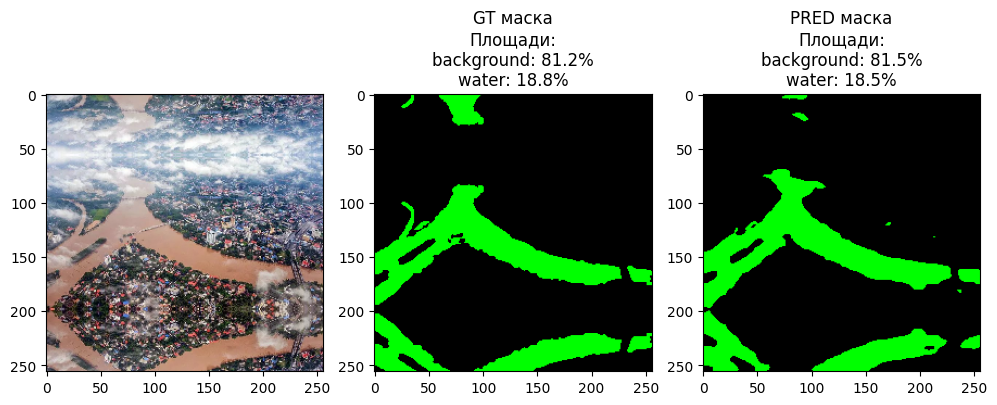

In [46]:
for i in range(1):
    n = np.random.choice(len(test_dataset))
    
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()
    
    label_mask = np.argmax(pr_mask, axis=0)
    print(label_mask.shape, image.shape, gt_mask.shape)

    visualize_predicts(image, np.argmax(gt_mask, axis=0), label_mask, normalized=True)

---